web: gunicorn app: app

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [28]:
data = pd.read_csv("E:/heart_disease/heart.csv")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [30]:
data.target.value_counts()

1    526
0    499
Name: target, dtype: int64

In [31]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
sex,1025.0,0.695610,0.460373,0.0,0.0,1.0,1.0,1.0
cp,1025.0,0.942439,1.029641,0.0,0.0,1.0,2.0,3.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
fbs,1025.0,0.149268,0.356527,0.0,0.0,0.0,0.0,1.0
restecg,1025.0,0.529756,0.527878,0.0,0.0,1.0,1.0,2.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
exang,1025.0,0.336585,0.472772,0.0,0.0,0.0,1.0,1.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2


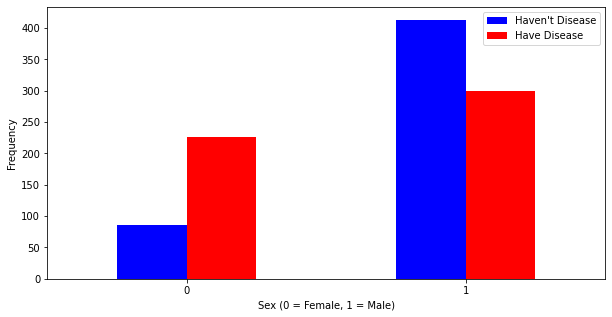

In [32]:
pd.crosstab(data.sex, data.target).plot(kind="bar",figsize=(10,5),color=['blue','red' ])

plt.xlabel('Sex (0 = Female, 1 = Male)') # X-Label

plt.xticks(rotation=0) # Get or set the current tick locations and labels of the x-axis.

plt.legend(["Haven't Disease", "Have Disease"]) # legend = Index

plt.ylabel('Frequency') # X-Label

plt.show() # Help to show our diagram

In [33]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)

IQR = Q3 - Q1

((data < (Q1 - 1.5 * IQR)) | (data < (Q3 - 1.5 * IQR))).sum()

age         100
sex           0
cp            0
trestbps     66
chol         80
fbs           0
restecg       0
thalach      95
exang         0
oldpeak       0
slope        74
ca            0
thal         71
target        0
dtype: int64

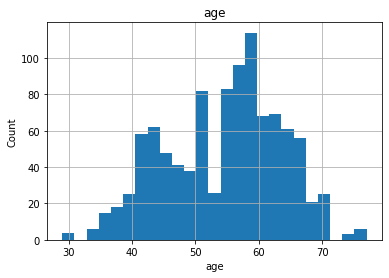

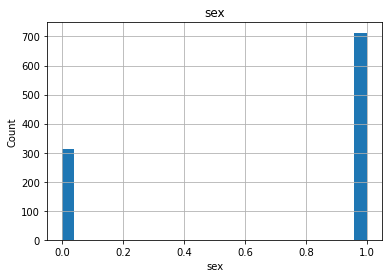

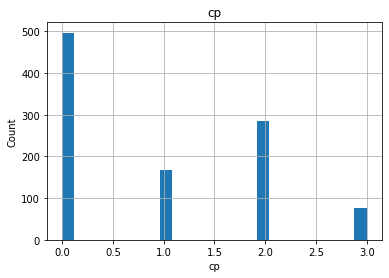

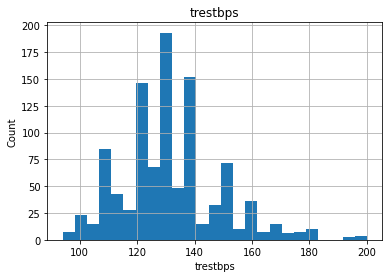

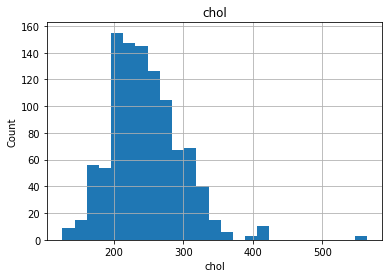

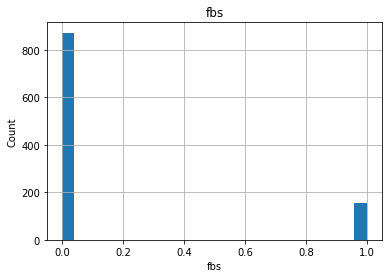

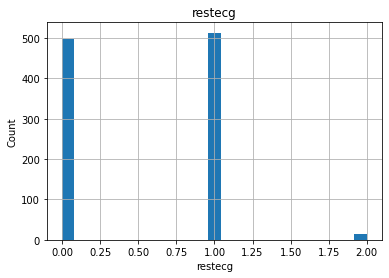

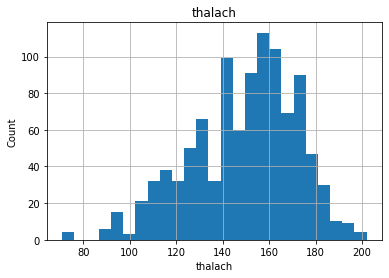

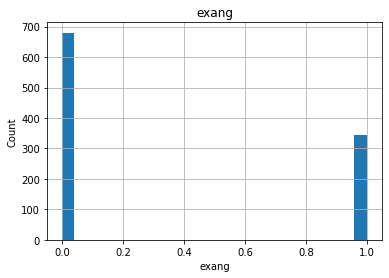

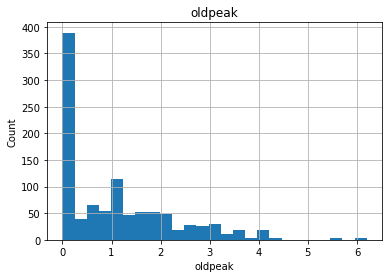

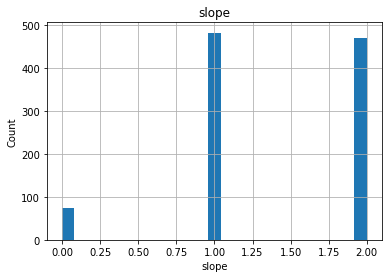

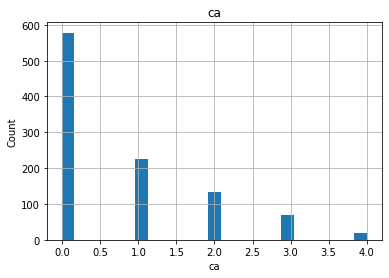

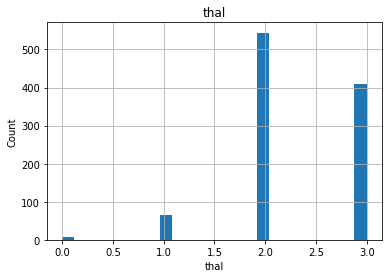

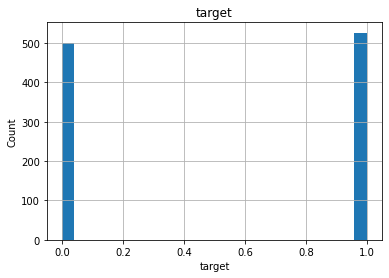

In [34]:
for feature in data:
    dataset = data.copy()
    dataset[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()


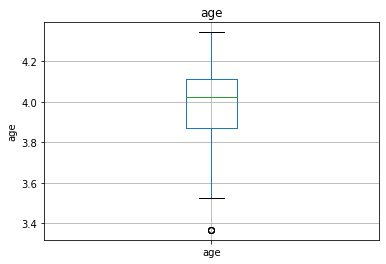

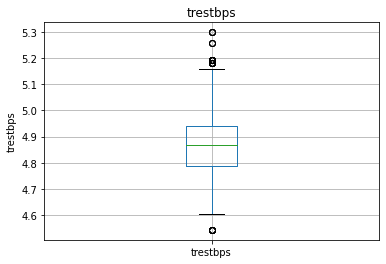

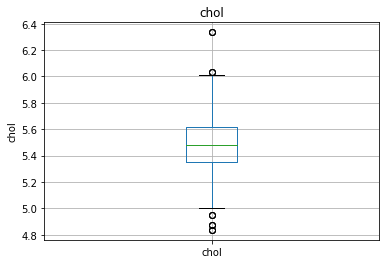

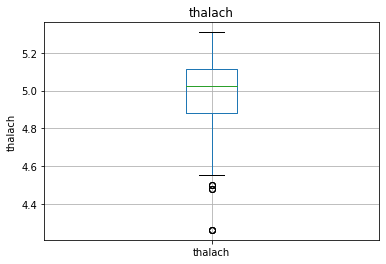

In [35]:
for feature in data:
    dataset = data.copy()

    if 0 in dataset[feature].unique():
        pass
    else:
        dataset[feature] = np.log(dataset[feature])
        dataset.boxplot(column=feature)
        plt.ylabel(feature)
        plt.title(feature)
        plt.show()



In [36]:
outliers = []

def detect_outliers(values):
    Threshold = 3
    mean_val = np.mean(values)
    std_val = np.std(values)

    for i in values:
        z_score = (i - mean_val) / std_val
        if np.abs(z_score) > Threshold:
            outliers.append(i)
    return outliers

out = detect_outliers(data['age'])
out


[]

In [37]:
outliers = []

def detect_outliers(values):
    Threshold = 3
    mean_val = np.mean(values)
    std_val = np.std(values)

    for i in values:
        z_score = (i - mean_val) / std_val
        if np.abs(z_score) > Threshold:
            outliers.append(i)
    
    return outliers

out = detect_outliers(data['trestbps'])
out


[192, 200, 192, 200, 192, 200, 200]

In [38]:
outliers = []

def detect_outliers(values):
    Threshold = 3
    mean_val = np.mean(values)
    std_val = np.std(values)

    for i in values:
        z_score = (i - mean_val) / std_val
        if np.abs(z_score) > Threshold:
            outliers.append(i)
    return outliers

out = detect_outliers(data['chol'])
out


[417, 564, 409, 564, 407, 564, 407, 409, 417, 407, 407, 417, 409]

In [39]:
outliers = []

def detect_outliers(values):
    Threshold = 3
    mean_val = np.mean(values)
    std_val = np.std(values)

    for i in values:
        z_score = (i - mean_val) / std_val
        if np.abs(z_score) > Threshold:
            outliers.append(i)
    return outliers

out = detect_outliers(data['thalach'])
out


[71, 71, 71, 71]

<AxesSubplot: >

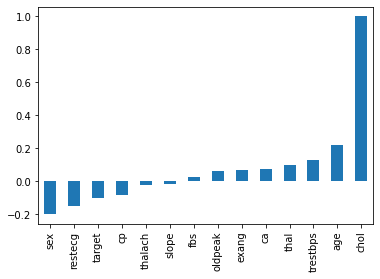

In [40]:
data.corr()['chol'].sort_values().plot(kind='bar')

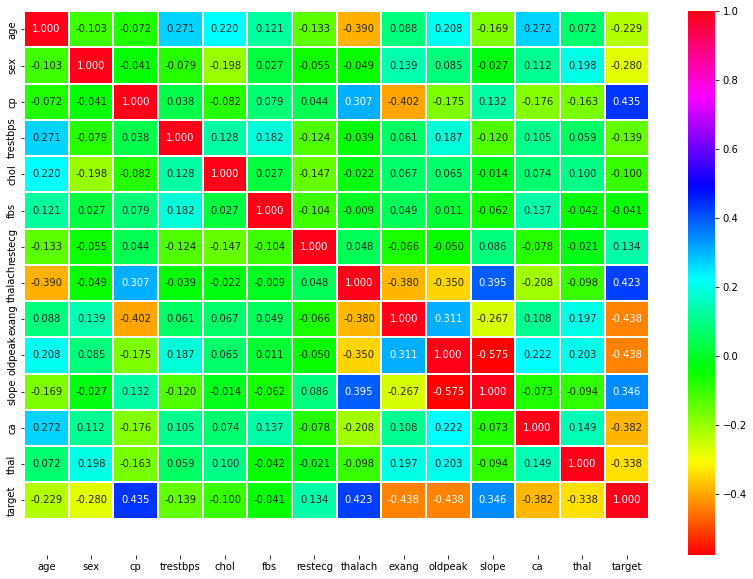

In [41]:
plt.figure(figsize=(14,10)) # Help to set figure size

sns.heatmap(data.corr(),annot=True,cmap='hsv',fmt='.3f',linewidths=2)

plt.ylim(15,0) # show us the exact number of values we want

plt.show()

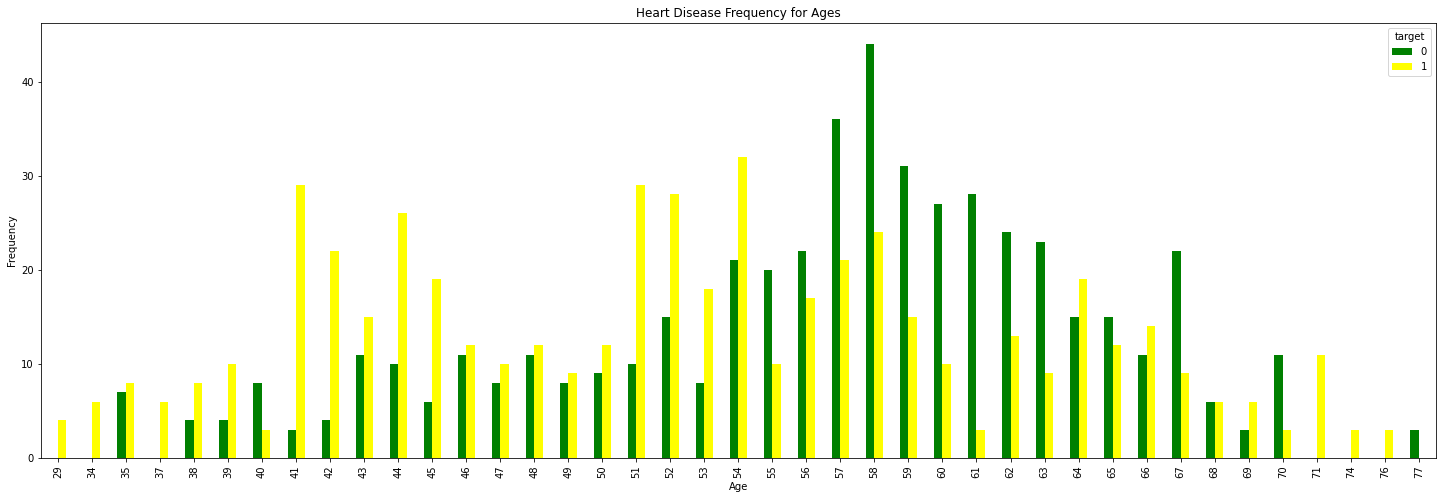

In [42]:
pd.crosstab(data.age,data.target).plot(kind="bar",figsize=(25,8),color=['green','yellow' ])
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [43]:
from sklearn.model_selection import train_test_split

X = data.drop('target', axis=1).values
y = data['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [44]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()

lr_model.fit(X_train,y_train)

lr_pred = lr_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,lr_pred))

              precision    recall  f1-score   support

           0       0.89      0.75      0.81       105
           1       0.78      0.90      0.83       100

    accuracy                           0.82       205
   macro avg       0.83      0.83      0.82       205
weighted avg       0.83      0.82      0.82       205



In [46]:
print(confusion_matrix(y_test,lr_pred))

[[79 26]
 [10 90]]


In [47]:
from sklearn import svm

clf_model = svm.SVC(kernel='rbf')

clf_model.fit(X_train,y_train)

clf_pred = clf_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,clf_pred))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       105
           1       0.87      0.91      0.89       100

    accuracy                           0.89       205
   macro avg       0.89      0.89      0.89       205
weighted avg       0.89      0.89      0.89       205



In [48]:
print(confusion_matrix(y_test,clf_pred))

[[91 14]
 [ 9 91]]


In [49]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200)

rf_model.fit(X_train,y_train)

rf_pred = rf_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       1.00      1.00      1.00       100

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



In [50]:
print(confusion_matrix(y_test,rf_pred))

[[105   0]
 [  0 100]]


In [51]:
# RANDOM FOREST GAVE US THE BEST RESULT

import joblib
joblib.dump(rf_model,"Heart_Disease_Prediction.pkl")

['Heart_Disease_Prediction.pkl']

In [52]:
# Testing our model performance
m = joblib.load('Heart_Disease_Prediction.pkl')
m.predict([[55,1,3,145,233,0,0,150,0,2.2,0,0,1]])

array([1], dtype=int64)